In [2]:
import dnnlib
import legacy
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.interpolate
import math
import random
import preprocessing.image_utils as itools
import cv2
import synthesis.synthesis as synth
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
network_pkl = "../t-golden-fid14.19.pkl"
device = torch.device('cuda')
G = synth.load_generator(network_pkl, device)

Loading networks from "../t-golden-fid14.19.pkl"...
Network loaded.


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
torch.Size([1, 3, 1024, 1024])


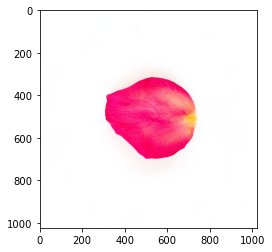

In [4]:
img = synth.synthesize_rand_image(50, G, device)
plt.imshow(img)

In [8]:
_kimgs = synth.synthesize_rand_interp([9, 300, 32], G, device, w_frames=4)

interpolating:  [9, 300, 32]
ws.shape original torch.Size([3, 16, 512])
ws[:1].shape torch.Size([3])
ws.shape torch.Size([1, 1, 3, 16, 512])
x.shape, y.shape (9,) (9, 16, 512)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.69it/s]


In [4]:
_kimg = synth.create_kaleidoscope(_kimgs)
plt.imshow(_kimg)

NameError: name 'kimgs' is not defined

In [3]:
def create_kaleidoscopes():
    for _ in range(100):
        num_seeds = random.randint(2, 20)
        w_frames = random.randint(2, 20)
        print(f'creating kaleidoscope with seeds: {num_seeds}, w_frames: {w_frames}')
        k = synth.synthesize_kaleidoscope(G, device, num_seeds, w_frames)
        filename = f'ns{num_seeds}-wf{w_frames}-.jpg'
        PIL.Image.fromarray(k, 'RGB').save(f'../kaleidoscopes/{}.jpg')

create_kaleidoscopes()

creating kaleidoscope with seeds: 7, w_frames: 9
creating kaleidoscope with seeds: 20, w_frames: 12
creating kaleidoscope with seeds: 4, w_frames: 10
creating kaleidoscope with seeds: 8, w_frames: 14
creating kaleidoscope with seeds: 17, w_frames: 3
creating kaleidoscope with seeds: 20, w_frames: 17
creating kaleidoscope with seeds: 5, w_frames: 13
creating kaleidoscope with seeds: 2, w_frames: 12
creating kaleidoscope with seeds: 5, w_frames: 3
creating kaleidoscope with seeds: 19, w_frames: 20
creating kaleidoscope with seeds: 7, w_frames: 18
creating kaleidoscope with seeds: 10, w_frames: 12
creating kaleidoscope with seeds: 16, w_frames: 19
creating kaleidoscope with seeds: 3, w_frames: 9
creating kaleidoscope with seeds: 15, w_frames: 10
creating kaleidoscope with seeds: 12, w_frames: 4
creating kaleidoscope with seeds: 13, w_frames: 3
creating kaleidoscope with seeds: 11, w_frames: 15
creating kaleidoscope with seeds: 10, w_frames: 8
creating kaleidoscope with seeds: 3, w_frames: